<a href="https://colab.research.google.com/github/EduFdezSoy/safety-first/blob/master/simple_with_maxpooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety helmet detector

Source: https://www.kaggle.com/ehddnr301/helmet-classification

In [1]:
# Uncomment for install tensorflow 1.15.
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 512kB 40.4MB/s 
     |████████████████████████████████| 3.8MB 39.9MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=7b1acdf9e0a7b4cf31bf86990ed34181142fd59c2374e8a24328d754c779ac69
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [2]:
# Imports
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from skimage import io, transform
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout
# Check Tensorflow version.
tf.version.VERSION

'1.15.0'

## 1. Loading Data

In [3]:
# Uncomment for clonning the repository
!git clone https://github.com/sergiorodenas/ml-data.git

Cloning into 'ml-data'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 13271 (delta 2), reused 0 (delta 0), pack-reused 13236
Receiving objects: 100% (13271/13271), 67.06 MiB | 36.49 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [4]:
# Image constants
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH1='./ml-data/helmet-dataset/Train_positive/Train_positive/'
PATH2='./ml-data/helmet-dataset/Train_negative/Train_negative/'

In [5]:
# Getting the images
filenames_list_yes = []
filenames_list_no = []

for filename in os.listdir(PATH1):
    filenames_list_yes.append(PATH1 + filename)
    
for filename in os.listdir(PATH2):
    filenames_list_no.append(PATH2 + filename)

df_yes = pd.DataFrame({
    'image': filenames_list_yes,
    'category': np.ones(len(filenames_list_yes), str)
})
df_no = pd.DataFrame({
    'image': filenames_list_no,
    'category': np.zeros(len(filenames_list_no), str)
})
print(df_yes.shape, df_no.shape)
df = df_yes.append(df_no, ignore_index=True)
print(df['image'][0])

(5160, 2) (6580, 2)
./ml-data/helmet-dataset/Train_positive/Train_positive/2338.jpg


## 2. Training data

In [6]:
# Hyperparameters
BATCH_SIZE=32
EPOCHS=100

In [7]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.15, stratify = df['category'], random_state = 3)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
print(train_df.shape)
print(valid_df.shape)

(9979, 2)
(1761, 2)


In [8]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   )

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col = 'image',
                                              y_col = 'category',
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              validate_filenames=False
                                             )

#we do not augment validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_gen = validation_datagen.flow_from_dataframe(
    valid_df, 
    x_col="image",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

Found 9979 non-validated image filenames belonging to 2 classes.
Found 1761 non-validated image filenames belonging to 2 classes.


In [9]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'Precision'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0

## 3. Train the model

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath = 'mask.weights.best.hdf5', save_best_only = True, save_weights_only = True)
early_stop = EarlyStopping(monitor='val_loss', patience=6)
callbacks = [learning_rate_reduction, checkpointer, early_stop]

In [12]:
start = time.time()

model.fit_generator(train_gen,
                    epochs = EPOCHS,
                    validation_data = valid_gen,
                    validation_steps=total_valid//BATCH_SIZE,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    callbacks = callbacks)

endTime = time.time() - start
print("Total time: ", endTime, "seconds")

Epoch 1/100
311/311 [==============================] - 18s 59ms/step - loss: 0.1930 - acc: 0.9248 - precision: 0.9115 - val_loss: 0.1062 - val_acc: 0.9665 - val_precision: 0.9612
Epoch 2/100
311/311 [==============================] - 11s 37ms/step - loss: 0.1013 - acc: 0.9623 - precision: 0.9520 - val_loss: 0.0997 - val_acc: 0.9790 - val_precision: 0.9755
Epoch 3/100
311/311 [==============================] - 12s 37ms/step - loss: 0.0890 - acc: 0.9678 - precision: 0.9582 - val_loss: 0.0718 - val_acc: 0.9750 - val_precision: 0.9828
Epoch 4/100
 54/311 [====>.........................] - ETA: 8s - loss: 0.0657 - acc: 0.9751 - precision: 0.9878
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
311/311 [==============================] - 11s 37ms/step - loss: 0.0696 - acc: 0.9756 - precision: 0.9675 - val_loss: 0.0649 - val_acc: 0.9756 - val_precision: 0.9880
Epoch 5/100
311/311 [==============================] - 11s 37ms/step - loss: 0.0545 - acc: 0.9811 - prec

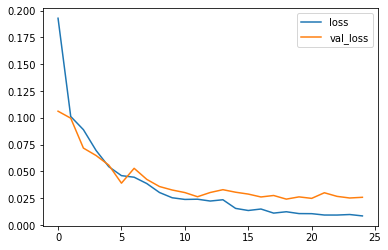

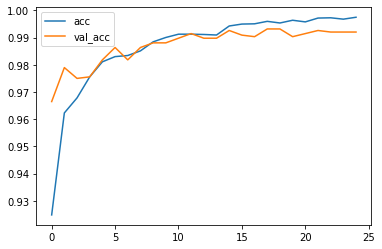

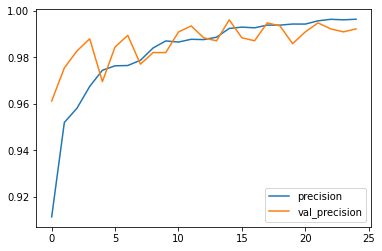

In [13]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['acc', 'val_acc']].plot()
loss[['precision', 'val_precision']].plot()

In [14]:
loss_mean = loss.mean()
loss_mean

loss             0.036506
acc              0.986513
precision        0.982230
val_loss         0.040748
val_acc          0.987205
val_precision    0.986352
lr               0.000327
dtype: float64

In [15]:
print("Epochs: ", len(model.history.epoch))
print("Train time: ", endTime, "seconds") 

Epochs:  25
Train time:  292.4101209640503 seconds


In [16]:
print("| Simple with maxpooling | {} | {} | {} | {} | {} | {} | {} | {} | {} |  |".format(loss_mean.acc, loss_mean.loss, loss_mean.val_acc, loss_mean.val_loss, loss_mean.precision, loss_mean.val_precision, loss_mean.lr, len(model.history.epoch), endTime))

| Simple with maxpooling | 0.9865125155448914 | 0.03650644569824707 | 0.98720454454422 | 0.04074789407055571 | 0.982229516506195 | 0.9863523221015931 | 0.00032665001548593865 | 25 | 292.4101209640503 |  |
